#### IMPORTING LIBRARYS


In [1]:
import time 
start=time.time()
import pandas as pd 
import numpy as np 
import seaborn as sns  
import nltk 
from nltk  import FreqDist,pos_tag
from random import randint 
#nltk.download('stopwords')
from nltk.corpus import stopwords,wordnet
import matplotlib.pyplot as plt  
from wordcloud import STOPWORDS,WordCloud  
from matplotlib import rcParams
from nltk.tokenize import sent_tokenize, word_tokenize  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import WordNetLemmatizer   
import spacy
from spacy import displacy  
from statistics import mode 
import  string as String 
from sklearn.model_selection import cross_val_predict,cross_val_score 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import load_diabetes 
from sklearn.decomposition import PCA  
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.neighbors import RadiusNeighborsRegressor 
from sklearn.cross_decomposition import PLSCanonical,PLSRegression
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor  
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

#### LOADING AND PREPARING DATA

In [2]:

df_train=pd.read_csv("./data/train.csv") 
df_essays=pd.DataFrame(df_train["full_text"])
df_test=pd.read_csv("./data/test.csv")   
y=df_train.drop(["text_id","full_text"],axis=1)  
essays=df_essays["full_text"]
essays=list(essays) 
essays=" ".join(essays)  
essays=('''"""''') +essays + ('''"""''')   
target_names=list(y)
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


## GLOBAL FUNCTIONS

In [3]:
english_words=[] 
file=open("./data/actual_all_words.txt","r")  
wfile=file.readlines() 
for word in wfile: 
    english_words.append(word.lower()) 
for i in range(0,len(english_words)):  
    english_words[i]=english_words[i].replace("\n","")    
NER = spacy.load("en_core_web_sm")     

In [4]:

stop_words=stopwords.words("english")     
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner']) 
load_model.max_length =len(essays) *2
def remove_unwanted(string,unwanted):  
    for i in unwanted:  
        if i == "'s" or i== '`s' or i == '´s':   
            if "let's" in string or "let´s" in string or "let`s" in string:
                string=string.replace("let's","lets")
                string=string.replace("let´s","lets")
                string=string.replace("let`s","lets")
            string=string.replace(i," is") 
        elif i == "'re" or i== '`re' or i == '´re': 
            string=string.replace(i," are") 
        elif i== "n't" or i == "n`t" or i== "n´t":  
            if "won't" in string or "won´t" in string or "won`t" in string:
                string=string.replace("won`t","wont")
                string=string.replace("won´t","wont")
                string=string.replace("won't","wont")
            string=string.replace(i," will not")   
        elif i == "'ll" or i == "´ll" or i == "`ll": 
            string=string.replace(i," will") 
        elif i == "'d" or i == "´d" or i == "`d": 
            string=string.replace(i," would")
        elif i == "'ve" or i == "´ve" or i == "`ve": 
            string=string.replace(i," have") 
        elif i == "'m" or i == "´m" or i == "`m": 
            string=string.replace(i," am") 
        else:
            string=string.replace(i," ")
    return string    
def filter_text(string,stop_words=stop_words,unique_words=True,filter_by_sw=True): 
    string=remove_unwanted(string,["'s","`s","´s","'re","`re","´re","n't","n´t","n`t","'ll","´ll","`ll","'d","´d","`d","'ve","`ve","´ve","'m","`m","´m","'",'"',".",",","`","!","?","´",':',"(",")","/",";"])  
    tokenized=word_tokenize(string) 
    filtered=tuple(tokenized)
    if filter_by_sw:
        filtered=tuple([word.casefold() for word in tokenized if word.casefold() not in stop_words])
    if unique_words:
        filtered =tuple(set(filtered))
    return filtered 
def get_num_words(string,unique_words=True,filter_by_sw=True):  
    filtered=filter_text(string,unique_words=unique_words,filter_by_sw=filter_by_sw)
    return len(filtered)
def makeWordcloud(text,stopwords=STOPWORDS,maxwords=300,width=800,height=800,color="black",column="fulltext"): 
    if isinstance(text,pd.core.frame.DataFrame):  
        newtext="\n".join(text[column])
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
    elif isinstance(text,str):  
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()
    elif isinstance(text,list) or isinstance(text,np.ndarray) or isinstance(text,pd.core.series.Series): 
        newtext=" ".join(text)
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
def create_txt_with_example(specific=randint(0,len(df_train["full_text"]))): 
    newExample=open("./examples/example_%d.txt" % specific,"w") 
    newExample.write(df_train["full_text"][specific]) 
    newExample.close()  
def getcommonwords(text,amount=10):  
    filtered=filter_text(text,unique_words=False) 
    freq=FreqDist(filtered) 
    return tuple([word[0] for word in freq.most_common(amount)]) 
def pos_tag_text(text,filter=False,to_dic=False): 
    tagged=pos_tag(text) 
    return tagged
def mistakeCounter(essay): 
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return len(final)   
def mistakelist(essay):  
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return final 
def getradicals(essay): 
    doc=load_model(" ".join(filter_text(essay,unique_words=False))) 
    radicals=[token.lemma_ for token in doc] 
    final=radicals
    for word in radicals:
        if word not in english_words:
            if word in final: 
                final.remove(word)
    return final  
def amountRadicals(essay): 
    radicals=set(getradicals(essay))
    return len(radicals) 
def stop_words_counter(essay): 
    filtered=filter_text(essay,unique_words=False,filter_by_sw=False)  
    a=[]
    for word in filtered: 
        if word.lower() in stop_words: 
            a.append(word.lower()) 
    return len(a);  
def transform_to_bag_of_words(essay): 
    vectorizer=CountVectorizer()
    bag=vectorizer.fit_transform(filter_text(essay,unique_words=False)) 
    return bag.toarray()

## CREATE AN EXAMPLE txt

In [5]:
#create_txt_with_example()  

## ADDING RELEVANT INFORMATION

### MAKING RELEVANT FILE

In [6]:
#df_relevant=df_train   
df_relevant=pd.read_csv("./relevant/relevant.csv")

### guide to pos_tag

In [7]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### GUIDE TO NER

In [8]:
NER.get_pipe('ner').labels  

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

### ADDING NUMBER OF WORDS PER ESSAY

In [9]:
""" df_train["full_text"]
e_string=df_essays["full_text"][300]
df_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] 
df_relevant """

' df_train["full_text"]\ne_string=df_essays["full_text"][300]\ndf_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] \ndf_relevant '

### ADDING 10 MOST COMMON WORDS OF EACH ESSAY

In [10]:
""" df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  
df_relevant """

' df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  \ndf_relevant '

### ADDING HOW MANY ORTOGRAPHY ERRORS

In [11]:
""" df_relevant["ort_mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] 
df_relevant      """

' df_relevant["ort_mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] \ndf_relevant      '

### GETTING RADICALS

In [12]:
""" df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]] 
df_relevant """

' df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]] \ndf_relevant '

### ADDING NUM OF STOPWORDS

In [13]:
""" df_relevant["amt_stopwords"]=[stop_words_counter(essay) for essay in df_train["full_text"]] 
df_relevant """

' df_relevant["amt_stopwords"]=[stop_words_counter(essay) for essay in df_train["full_text"]] \ndf_relevant '

## TESTING

## VISUALIZING DATA 

### SEEING REGULAR WORD CLOUD

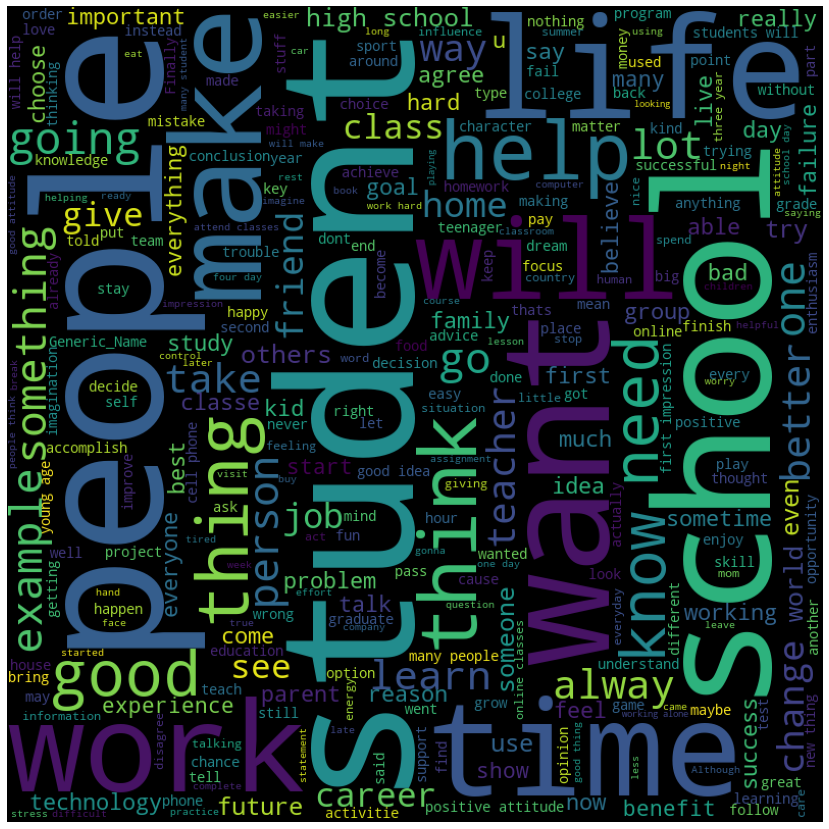

In [14]:
makeWordcloud(essays) 

### SEEING WORDCLOUD OF RADICALS

In [15]:
#radicals=getradicals(essays)

In [16]:
#makeWordcloud(" ".join(radicals)) 

### SEEING MOST COMMON WORDS FREQUENCY

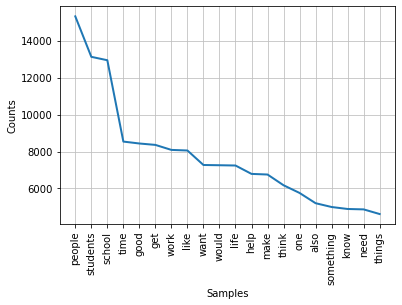

In [17]:
filtered_words=filter_text(essays,unique_words=False) 
common=FreqDist(filtered_words)
common.plot(20) 
plt.show()

### SEEING HISTOGRAM OF EACH TARGET

dimX:2 dimY:3
0
1
2
3
4
5


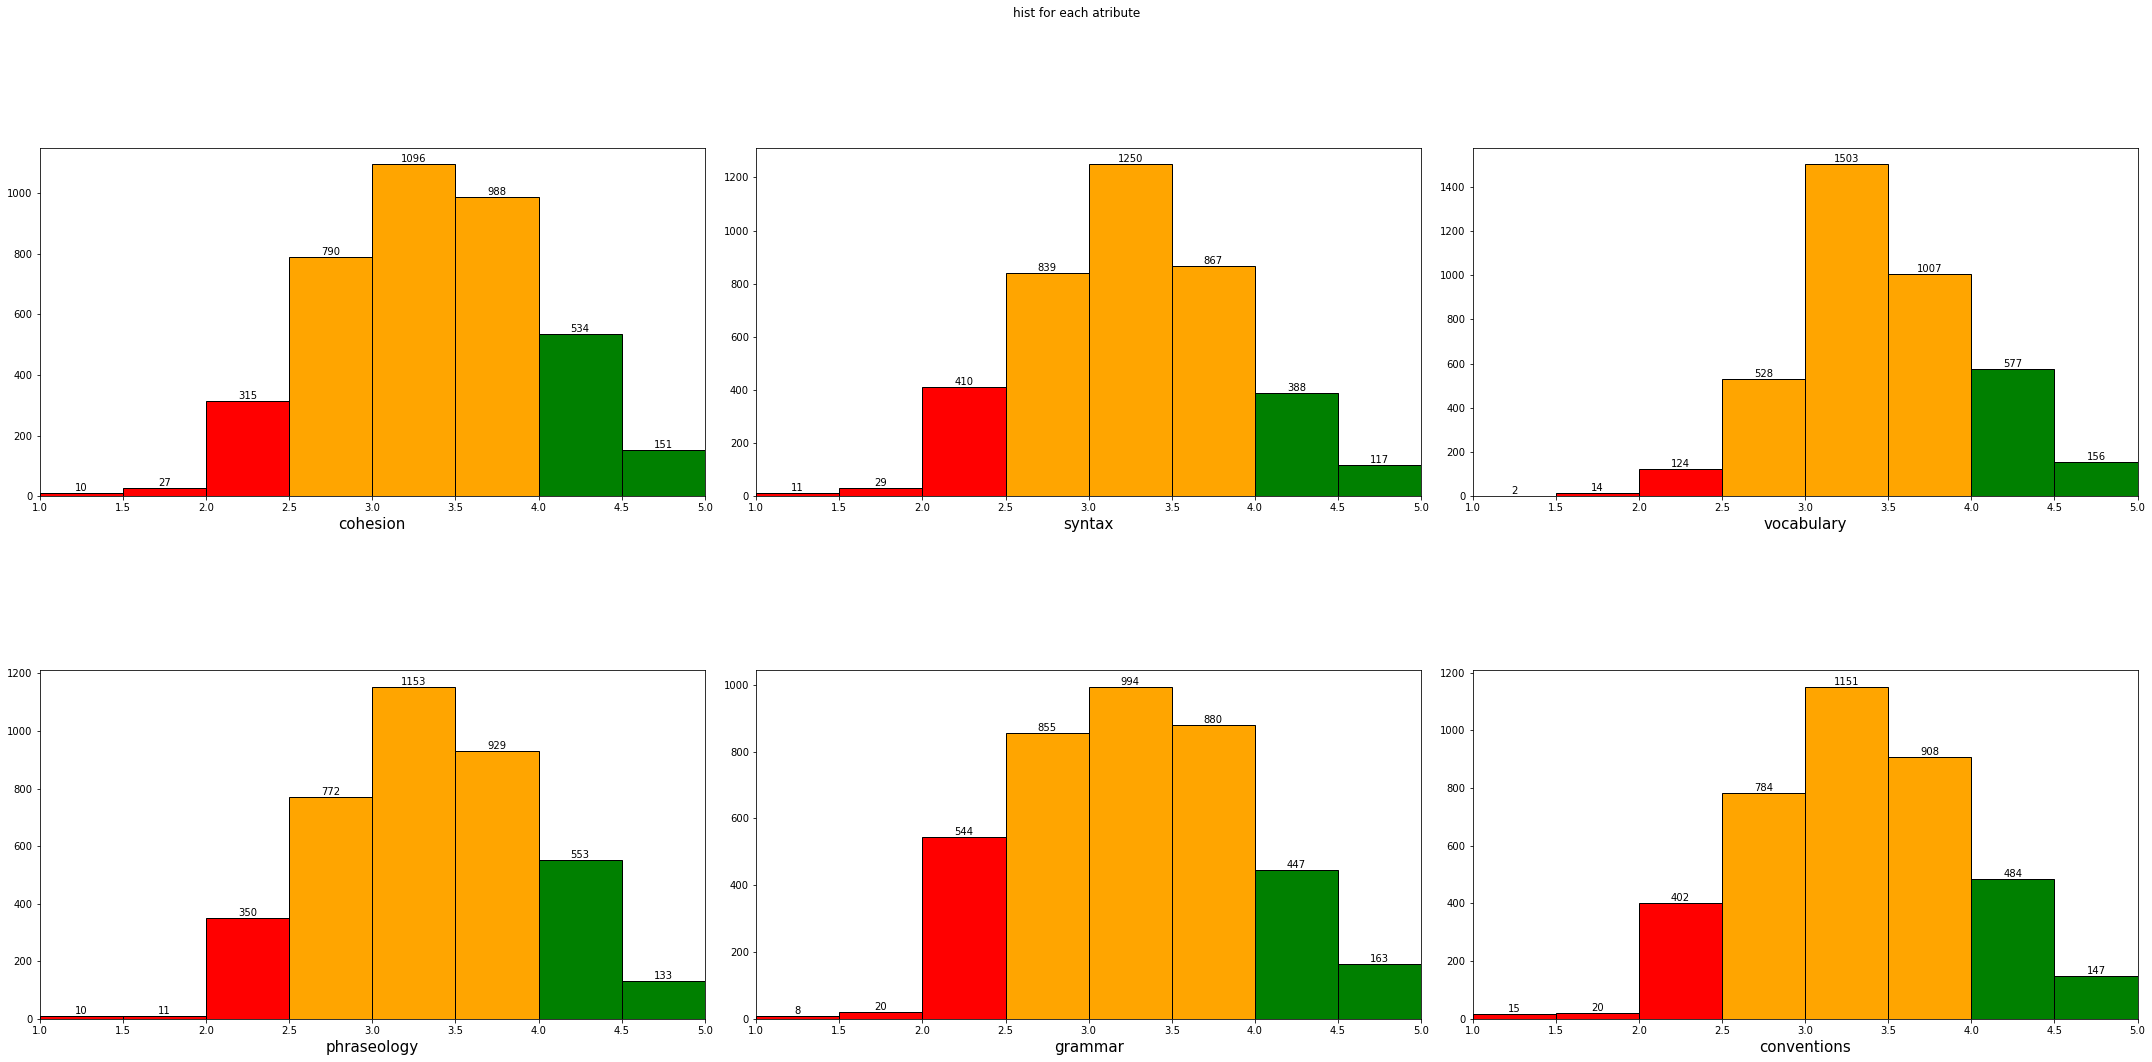

In [18]:

fig,ax =plt.subplots(2,3) 
fig.suptitle("hist for each atribute")   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]     
print("dimX:%d dimY:%d" % (dimX,dimY))
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j 
        print(oneDIndex)
        N, bins, patches=ax[i,j].hist(y[target_names[oneDIndex]],edgecolor="black",bins=8)   
        for k in range(0,3):
            patches[k].set_facecolor("red") 
        for k in range(3,6): 
            patches[k].set_facecolor("orange")
        for k in range(6,len(patches)):  
            patches[k].set_facecolor("green")
        ax[i,j].bar_label(patches)
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15)  
        ax[i,j].set_xbound(lower=1.0,upper=5.0)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF MISTAKES

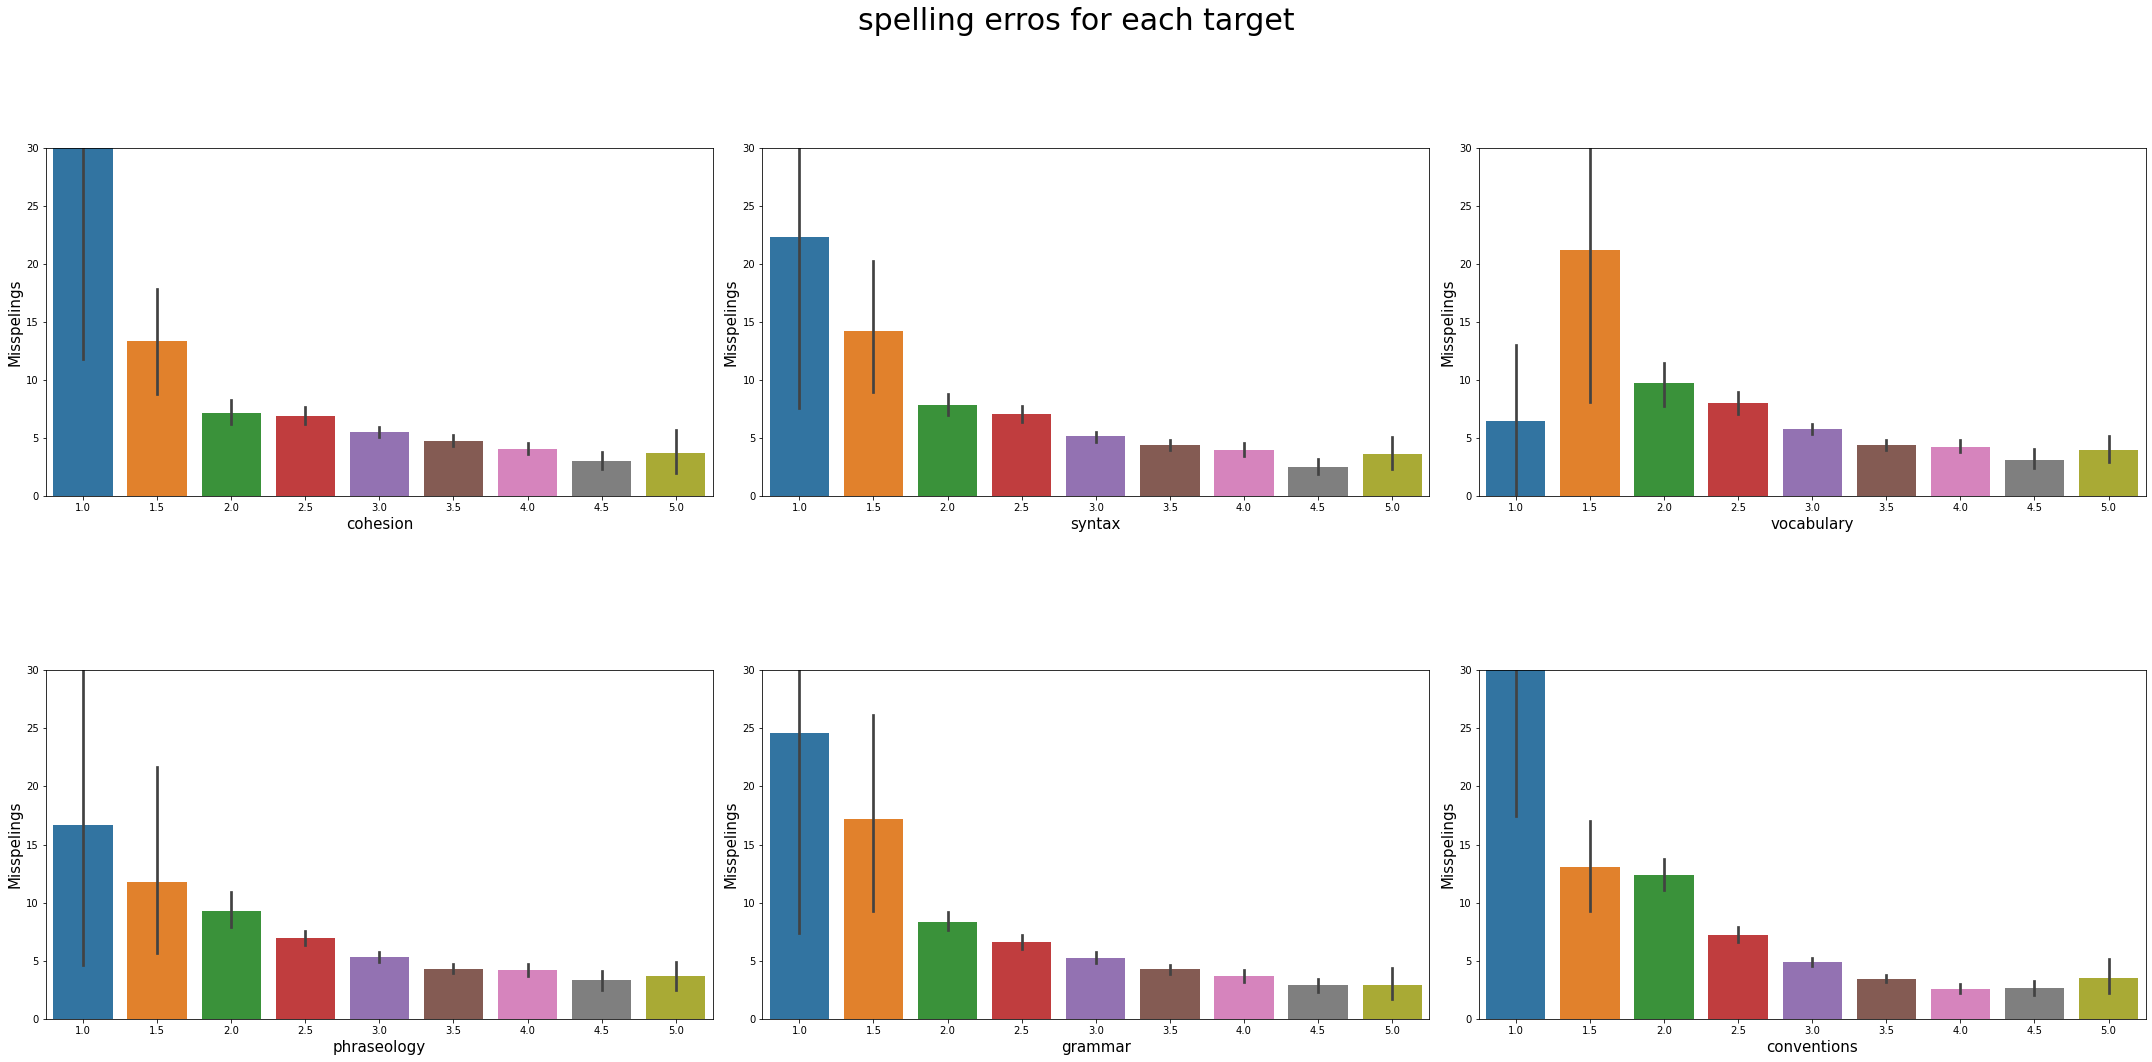

In [19]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("spelling erros for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="ort_mistakes",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Misspelings",size=15) 
        ax[i,j].set_ylim(0,30)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

#sns.barplot(data=df_relevant,x="grammar",y="ort_mistakes")

### MAKING HIST OF RADICALS

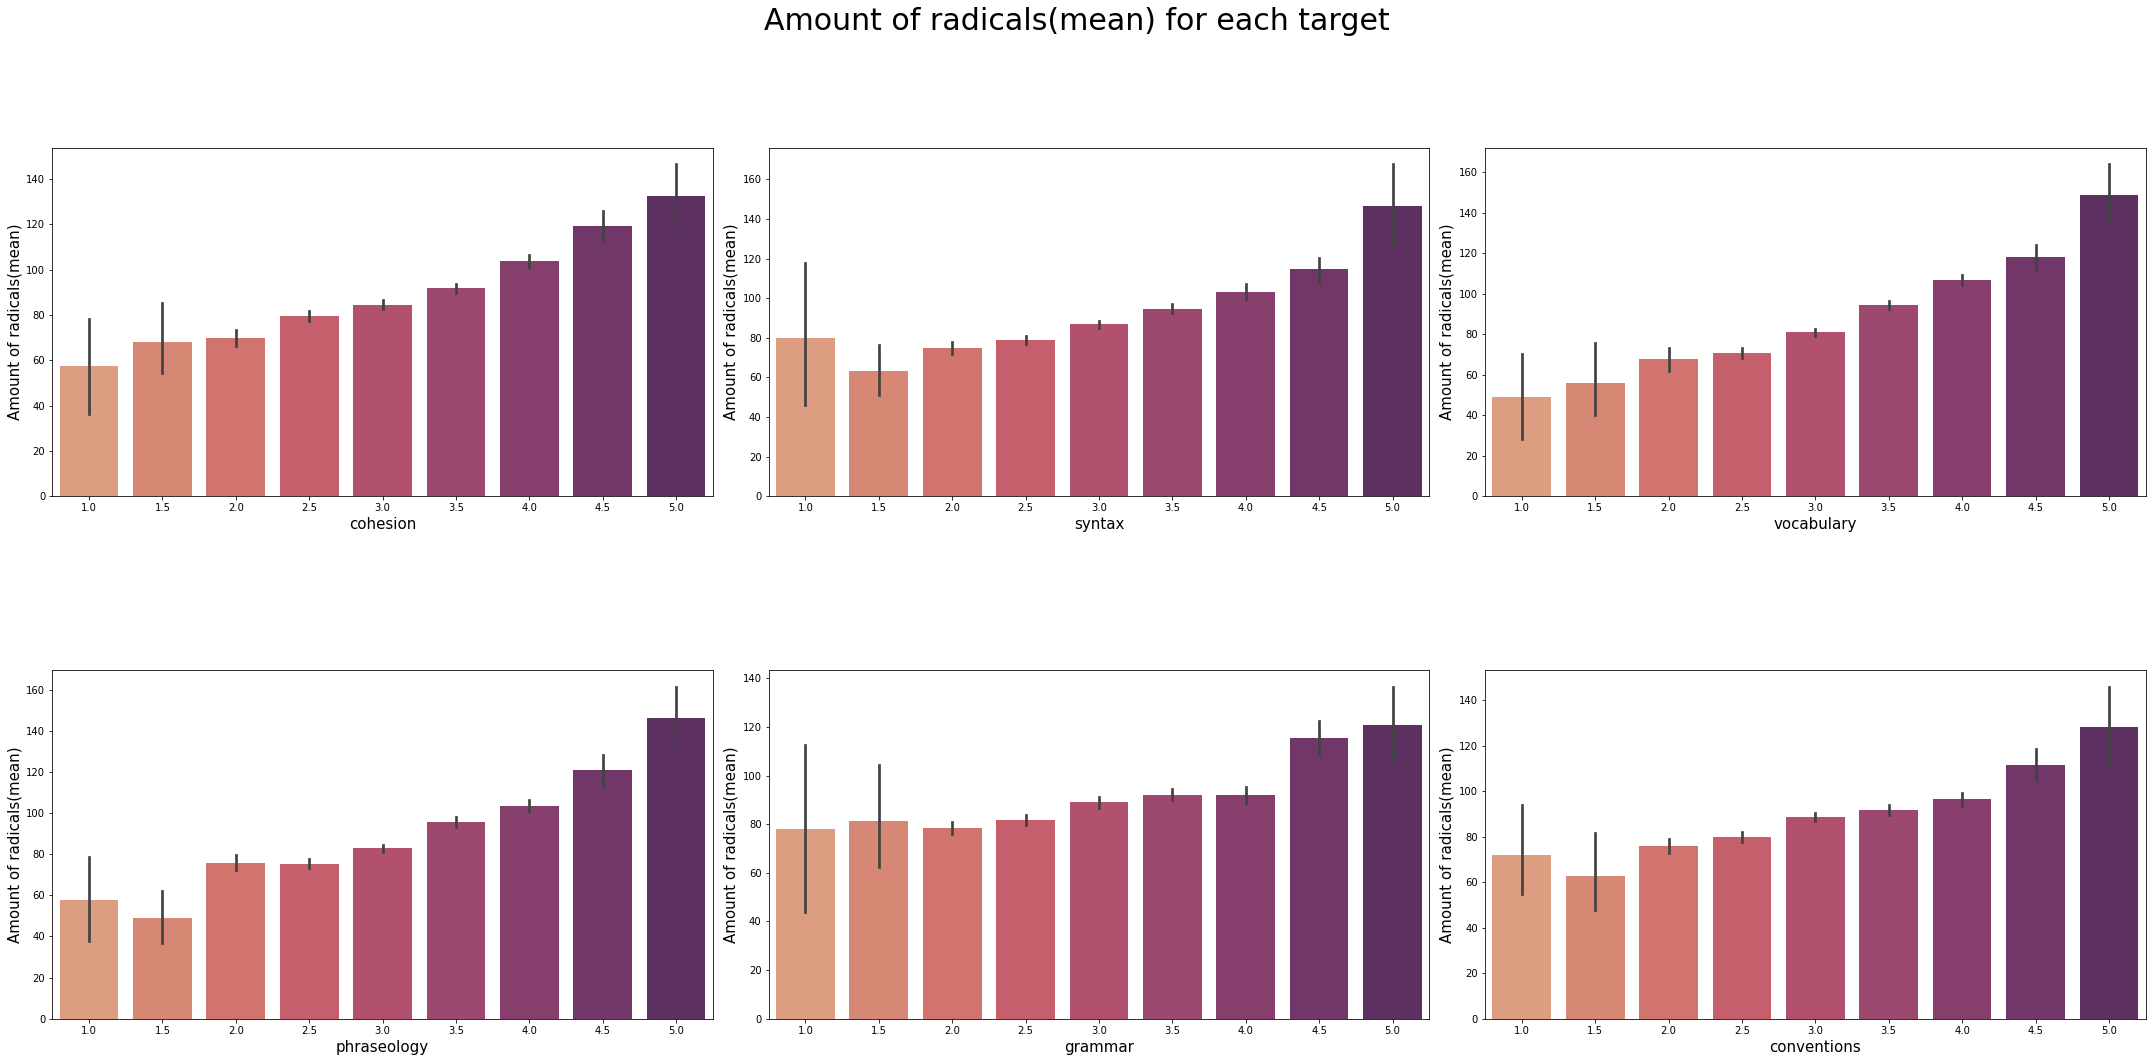

In [20]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of radicals(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="amt_radicals",palette="flare",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Amount of radicals(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF AMOUNT OF WORDS

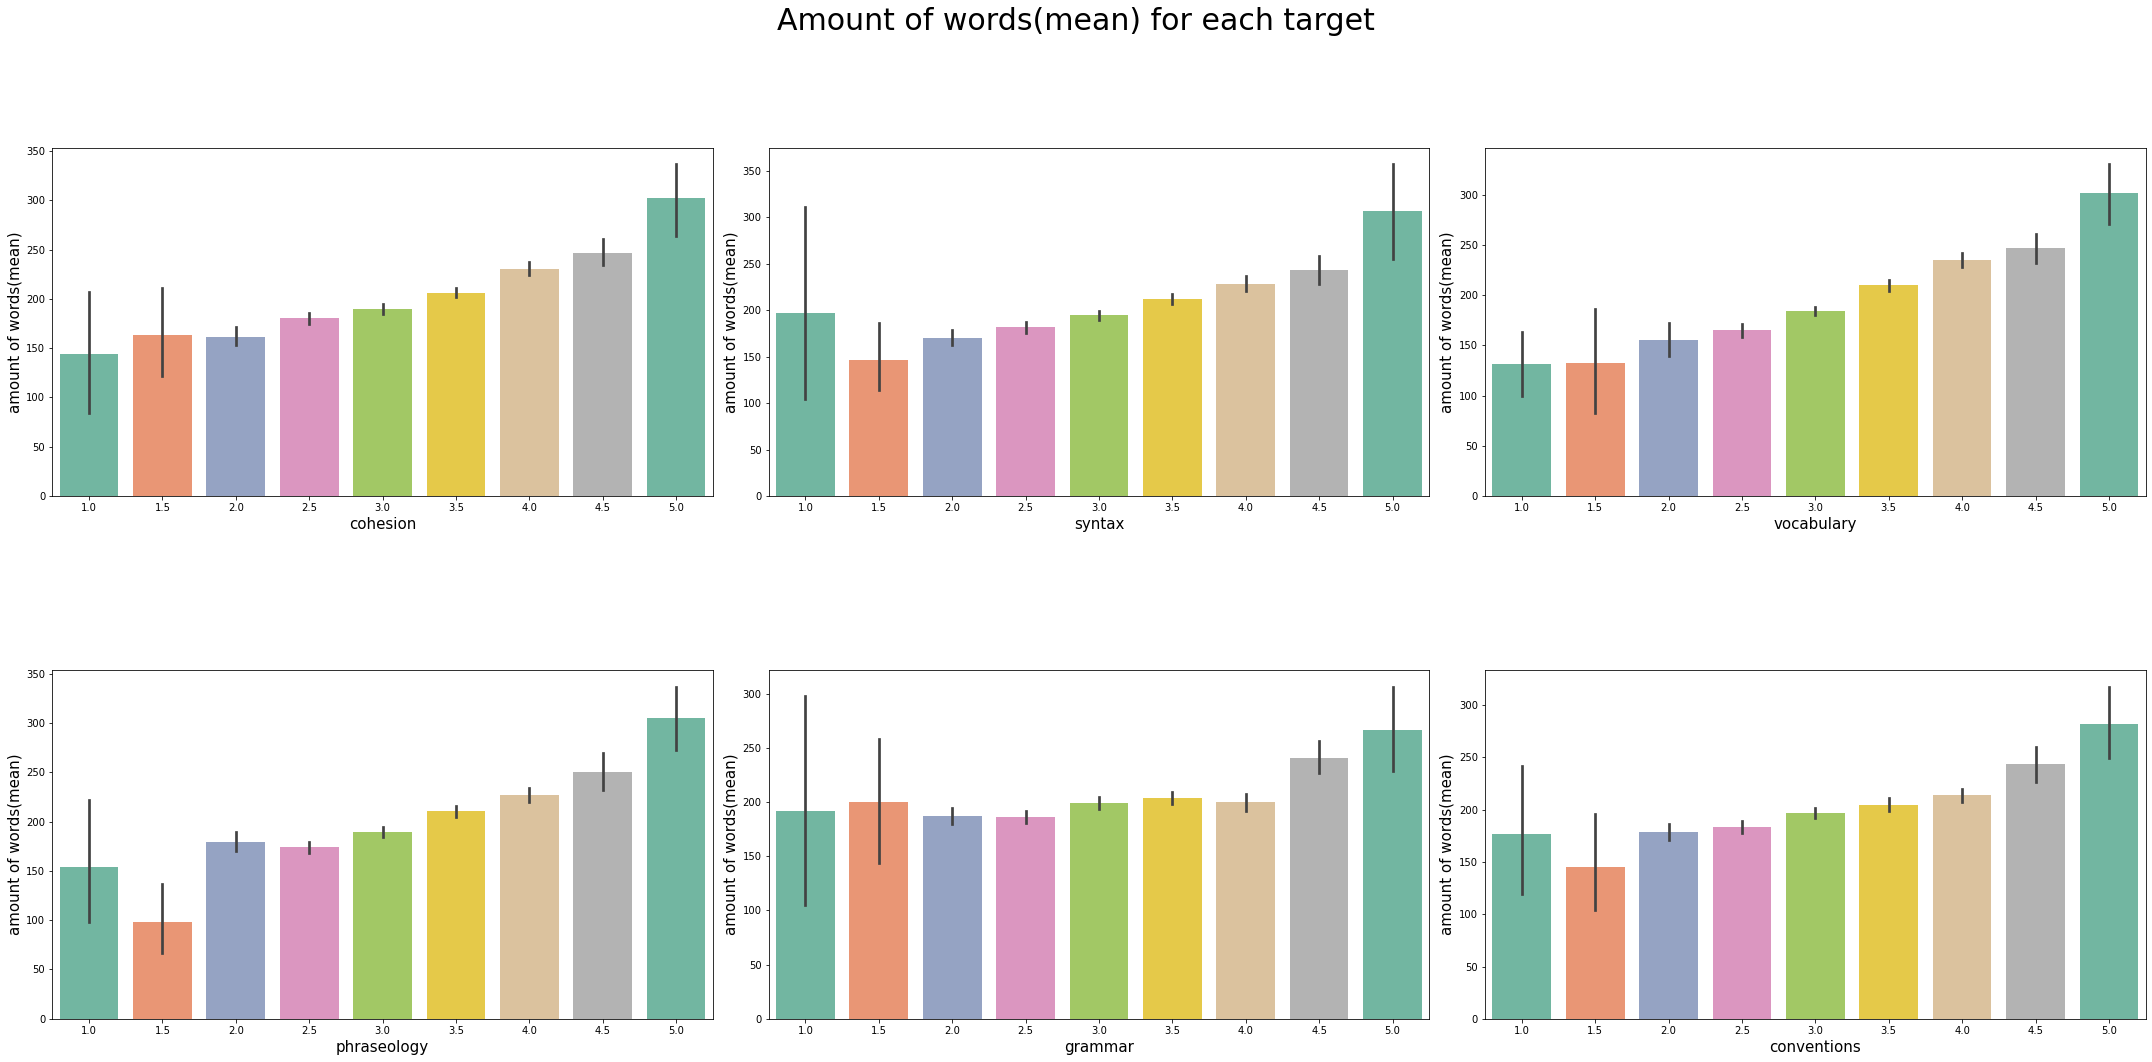

In [21]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of words(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="n_of_words",palette="Set2",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("amount of words(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF AMOUNT OF STOPWORDS

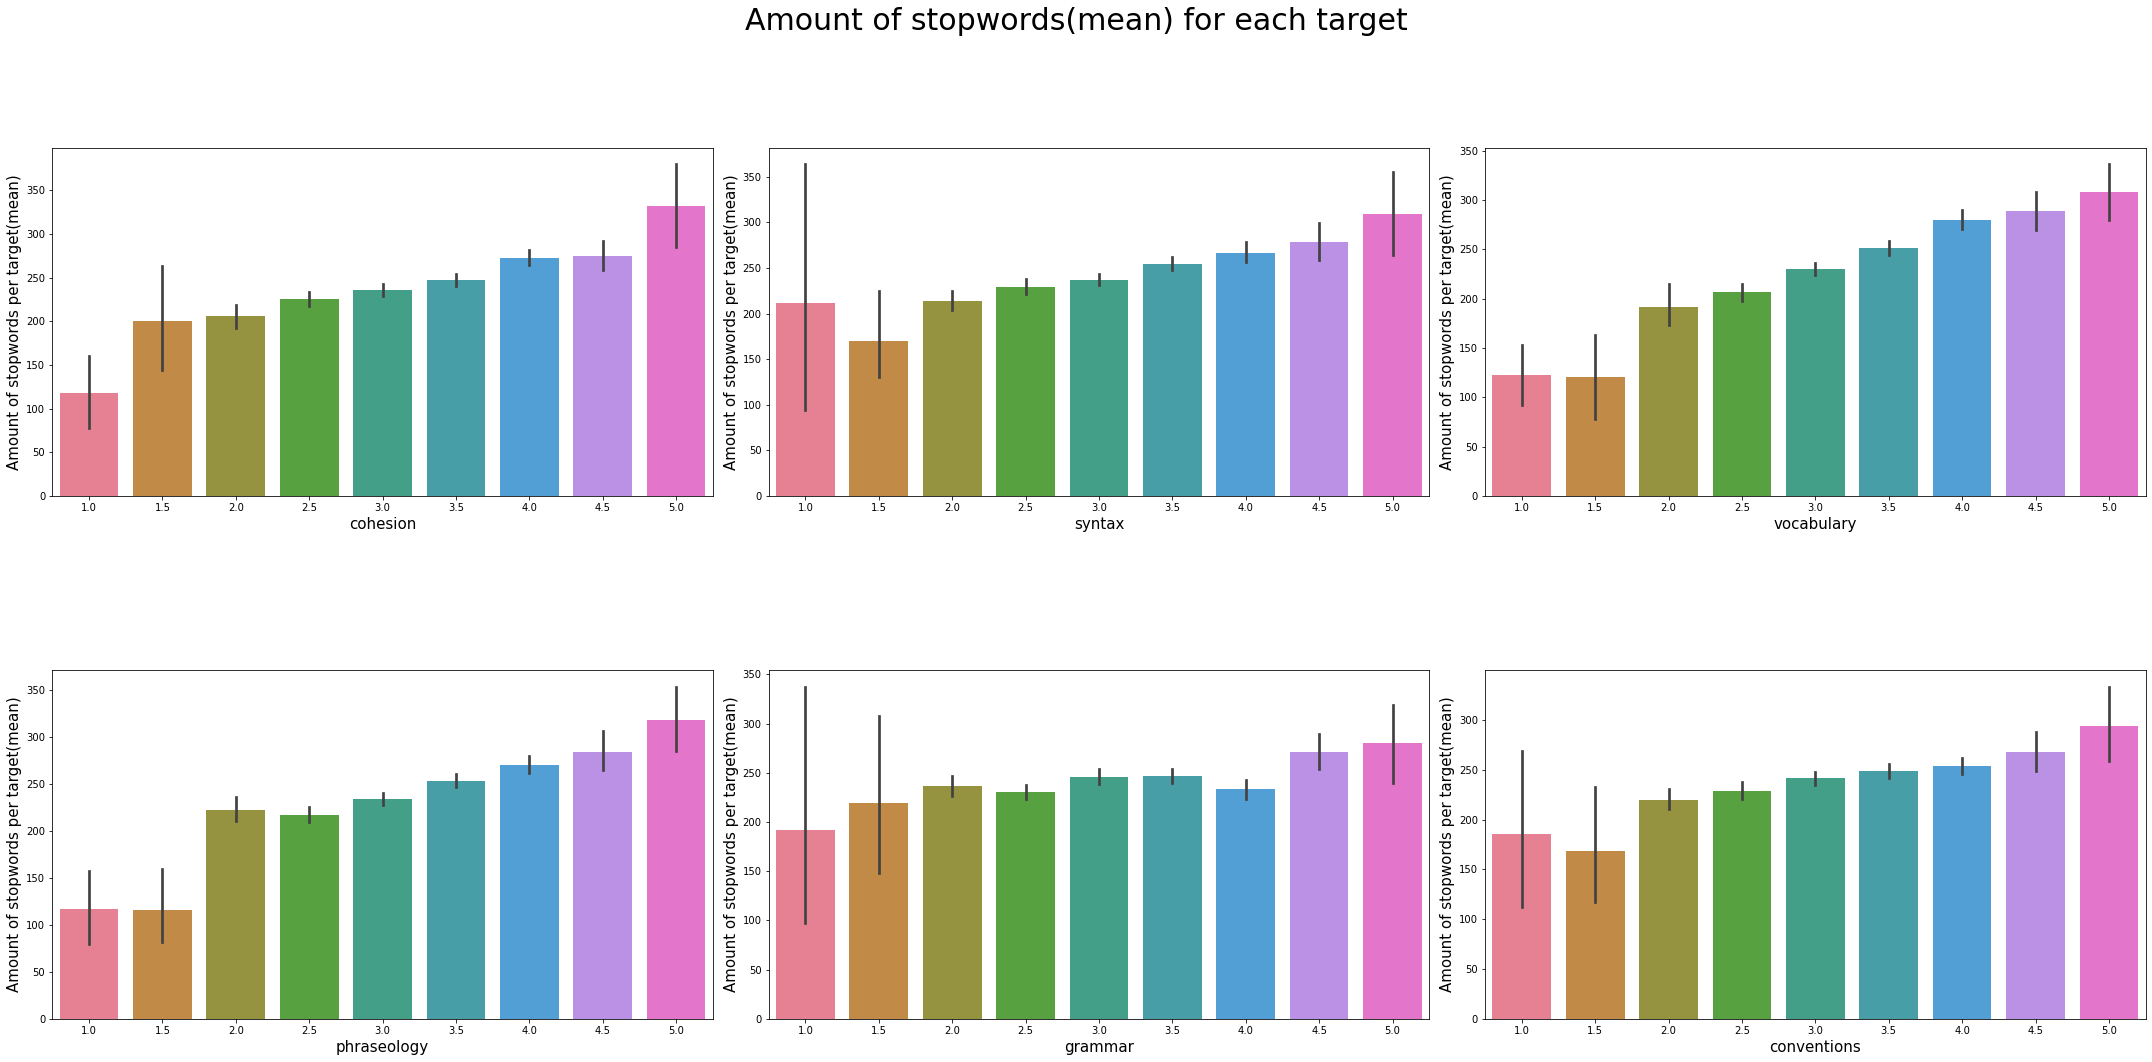

In [22]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of stopwords(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="amt_stopwords",palette="husl",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Amount of stopwords per target(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)

## SAVING RELEVANT FILE TO CSV

In [23]:
df_relevant.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,ort_mistakes,amt_radicals,amt_stopwords
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,197.701867,5.582204,88.028893,240.545641
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,86.542751,8.247720,34.454573,113.835489
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,6.000000,6.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,135.000000,0.000000,62.000000,161.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,185.000000,2.000000,83.000000,220.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,244.000000,8.000000,107.000000,295.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,579.000000,136.000000,255.000000,853.000000


In [24]:
df_relevant 

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129,"('students', 'go', 'home', 'u', 'wont', 'get',...",1,81,135
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,215,"('change', 'different', 'see', 'understand', '...",0,80,323
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,133,"('average', 'sports', 'school', 'activities', ...",0,56,202
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,282,"('make', 'choices', 'others', 'want', 'people'...",0,125,484
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"('people', 'act', 'change', 'kindess', 'person...",10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"('believe', 'could', 'using', 'cellphones', 'u...",16,56,83
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,214,"('students', 'work', 'group', 'working', 'get'...",15,98,253
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"('problem', 'best', 'every', 'get', 'chance', ...",9,59,150
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,228,"('people', 'others', 'example', 'influence', '...",1,94,294


In [25]:
#df_relevant.to_csv("./relevant/relevant.csv",index=False) 
e_string=df_relevant["full_text"][1540] 
df_relevant.iloc[2389] 

text_id                                                   B1AFACE6704E
full_text            I agree with Michelangelo's statement as I hav...
cohesion                                                           5.0
syntax                                                             5.0
vocabulary                                                         5.0
phraseology                                                        5.0
grammar                                                            5.0
conventions                                                        5.0
n_of_words                                                         457
most_common_words    ('high', 'setting', 'goals', 'aim', 'goal', 'c...
ort_mistakes                                                         4
amt_radicals                                                       155
amt_stopwords                                                      466
Name: 2389, dtype: object

## TRAINING MODEL

In [26]:
X=df_relevant.drop(columns=target_names).copy() 
X["full_text"]=[transform_to_bag_of_words(essay) for essay in df_essays["full_text"]] 
X=X.set_index("text_id")

In [27]:
def getModels(): 
   return {"LINEAR REGRESSION":MultiOutputRegressor(LinearRegression()), 
    "RANDOM FOREST":MultiOutputRegressor(RandomForestRegressor(max_depth=4)),
    "ADA BOOST":MultiOutputRegressor(AdaBoostRegressor()), 
    "DECISION TREE":MultiOutputRegressor(DecisionTreeRegressor()), 
    "SGD":MultiOutputRegressor(make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))), 
    "KNN":MultiOutputRegressor(KNeighborsRegressor()),
    "RNN":MultiOutputRegressor(RadiusNeighborsRegressor()),
    "EXTRA TREES":MultiOutputRegressor(ExtraTreesRegressor(random_state=0,max_depth=6)),
    "GRADIENT BOOST":MultiOutputRegressor(GradientBoostingRegressor(random_state=0))}

Trying with smaller example

In [28]:
e_string=df_train["full_text"][3385]  
e_string  
bag=transform_to_bag_of_words(e_string)  
tempX= df_relevant.iloc[3385].drop(labels=y.columns) 
tempX 
tempY= df_relevant.iloc[3385].drop(labels=X.columns) 
tempX["full_text"]=bag 
tempX  
arraystring=[] 
arraystring.extend([transform_to_bag_of_words(df_train["full_text"][3385]),transform_to_bag_of_words(df_train["full_text"][3498]),transform_to_bag_of_words(df_train["full_text"][2591]),transform_to_bag_of_words(df_train["full_text"][2576]),
transform_to_bag_of_words(df_train["full_text"][2389]),transform_to_bag_of_words(df_train["full_text"][1540])]) 
tempx={} 
tempx[3385] =df_relevant.iloc[3385].drop(labels=y.columns) 
tempx[3498] =df_relevant.iloc[3498].drop(labels=y.columns) 
tempx[2591] =df_relevant.iloc[2591].drop(labels=y.columns) 
tempx[2576] =df_relevant.iloc[2576].drop(labels=y.columns) 
tempx[2389] =df_relevant.iloc[2389].drop(labels=y.columns) 
tempx[1540] =df_relevant.iloc[1540].drop(labels=y.columns)  
tempy={}
tempy[3385] =df_relevant.iloc[3385].drop(labels=X.columns) 
tempy[3498] =df_relevant.iloc[3498].drop(labels=X.columns) 
tempy[2591] =df_relevant.iloc[2591].drop(labels=X.columns) 
tempy[2576] =df_relevant.iloc[2576].drop(labels=X.columns) 
tempy[2389] =df_relevant.iloc[2389].drop(labels=X.columns) 
tempy[1540] =df_relevant.iloc[1540].drop(labels=X.columns)  
tempy=pd.DataFrame(tempy).T  
tempx[3385]=tempx[3385].drop("most_common_words")
tempx[3498]=tempx[3498].drop("most_common_words")
tempx[2591]=tempx[2591].drop("most_common_words")
tempx[2576]=tempx[2576].drop("most_common_words")
tempx[2389]=tempx[2389].drop("most_common_words")
tempx[1540]=tempx[1540].drop("most_common_words")
tempx=pd.DataFrame(tempx).T
tempx["full_text"]=arraystring 
tempx=tempx.set_index("text_id")  

In [29]:
models=getModels() 
scores={}
for i in models.keys(): 
    scores[i]=cross_val_score(models[i],X,y,cv=10)

""" scores =cross_val_score(getModel(),X,y,cv=10) 
print("R2: ",np.absolute(np.mean(scores))) """ 


scores

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\multioutput.py", line 202, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "c:\Users\Le

{'LINEAR REGRESSION': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RANDOM FOREST': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'ADA BOOST': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'DECISION TREE': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'SGD': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'KNN': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RNN': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'EXTRA TREES': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'GRADIENT BOOST': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

## Running time

In [30]:
end=time.time() 
print(end-start)

28.430107355117798
